In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

num_hours = 5000

# Generate synthetic data
time_of_day = np.arange(num_hours) % 24  # 0 to 23 hours
demand = np.random.uniform(50, 150, num_hours)  # Demand in MW
supply_renewable = np.random.uniform(20, 80, num_hours)  # Renewable supply in MW
supply_nonrenewable = np.random.uniform(60, 120, num_hours)  # Non-renewable supply in MW
battery_level = np.random.uniform(10, 100, num_hours)  # Battery level in MWh

# Simplified weather conditions affecting renewable energy production
weather_conditions = ['Sunny', 'Cloudy', 'Windy', 'Night']
weather = np.random.choice(weather_conditions, num_hours)

synthetic_data = pd.DataFrame({
    'Time_of_Day': time_of_day,
    'Demand': demand,
    'Supply_Renewable': supply_renewable,
    'Supply_NonRenewable': supply_nonrenewable,
    'Battery_Level': battery_level,
    'Weather_Conditions': weather
})

print(synthetic_data)


      Time_of_Day      Demand  Supply_Renewable  Supply_NonRenewable  \
0               0   87.454012         43.618131            82.418449   
1               1  145.071431         48.406140            79.974726   
2               2  123.199394         71.272844            70.569235   
3               3  109.865848         40.400263            96.436000   
4               4   65.601864         72.178981            88.597450   
...           ...         ...               ...                  ...   
4995            3  139.739732         71.459359            99.053009   
4996            4   61.938101         73.850530            70.667900   
4997            5   82.784284         76.802475            63.074372   
4998            6  131.574538         43.849280           100.977696   
4999            7  109.731238         33.028424            75.064741   

      Battery_Level Weather_Conditions  
0         54.970322             Cloudy  
1         77.207210             Cloudy  
2         60

In [ ]:
class EnergyGridEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.optimal_battery_level = 50

    def reset(self):
        self.current_step = 0
        return self.get_state()

    def get_state(self):
        row = self.data.iloc[self.current_step]
        return (row['Time_of_Day'], row['Weather_Conditions'], row['Demand'], row['Supply_Renewable'], row['Supply_NonRenewable'], row['Battery_Level'])

    def step(self, action):
        row = self.data.iloc[self.current_step]
        demand = row['Demand']
        renewable_supply = row['Supply_Renewable']
        nonrenewable_supply = row['Supply_NonRenewable']
        battery_level = row['Battery_Level']

        energy_used, renewable_used, battery_used = self.perform_action(action, demand, renewable_supply, nonrenewable_supply, battery_level)
        reward = self.calculate_reward(demand, energy_used, renewable_used, battery_used, battery_level)

        self.current_step += 1
        done = self.current_step == len(self.data)
        next_state = self.get_state() if not done else None

        return next_state, reward, done

    def perform_action(self, action, demand, renewable_supply, nonrenewable_supply, battery_level):
        energy_used = renewable_used = battery_used = 0

        if action == 0:
            renewable_used = min(demand, renewable_supply)
            battery_needed = demand - renewable_used
            battery_used = min(battery_needed, battery_level)
            energy_used = renewable_used + battery_used

        elif action == 1:
            energy_used = min(demand, nonrenewable_supply)

        elif action == 2:
            renewable_used = min(demand, renewable_supply)
            remaining_demand = demand - renewable_used
            energy_used = renewable_used + min(remaining_demand, nonrenewable_supply + battery_level)
            battery_used = min(remaining_demand - nonrenewable_supply, battery_level)

        return energy_used, renewable_used, battery_used

    def calculate_reward(self, demand, energy_used, renewable_used, battery_used, battery_level):
        demand_penalty = -10 if energy_used < demand else 0
        renewable_reward = renewable_used / max(demand, 1)
        battery_penalty = battery_used / max(demand, 1)
        sustainability_penalty = -abs(battery_level - self.optimal_battery_level) / self.optimal_battery_level

        return renewable_reward - battery_penalty + demand_penalty + sustainability_penalty


In [ ]:
def train_agent(env, episodes=100, learning_rate=0.1, discount_rate=0.95, exploration_rate=1.0, exploration_decay=0.99, exploration_min=0.01):
    actions = [0, 1, 2]
    q_table = {}
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < exploration_rate:
                action = np.random.choice(actions)
            else:
                q_values = [q_table.get((state, a), 0) for a in actions]
                action = np.argmax(q_values)

            next_state, reward, done = env.step(action)
            total_reward += reward

            old_q_value = q_table.get((state, action), 0)
            next_max_q = max([q_table.get((next_state, a), 0) for a in actions], default=0)
            new_q_value = old_q_value + learning_rate * (reward + discount_rate * next_max_q - old_q_value)
            q_table[(state, action)] = new_q_value

            state = next_state

        exploration_rate = max(exploration_min, exploration_rate * exploration_decay)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_rewards.append(total_reward)

    return q_table, total_rewards



In [ ]:
def demonstrate_policy(env, q_table):
    state = env.reset()
    done = False
    total_reward = 0
    actions_taken = []
    battery_levels = []

    while not done:
        action = np.argmax([q_table.get((state, a), 0) for a in actions])
        next_state, reward, done = env.step(action)
        total_reward += reward
        print(f"State: {state}, Action: {action}, Reward: {reward}")
        actions_taken.append(action)


        if not done:
            battery_levels.append(next_state[5])
        else:
            battery_levels.append("N/A")

        state = next_state

    print(f"Total Reward: {total_reward}")

    plt.figure(figsize=(14, 7))
    plt.step(range(len(actions_taken)), actions_taken, where='mid')
    plt.title('Actions Taken During an Episode')
    plt.xlabel('Time Step')
    plt.ylabel('Action')
    plt.grid(True)
    plt.show()




Episode 1/100, Total Reward: -18453.581685874226
Episode 2/100, Total Reward: -18073.51508738835
Episode 3/100, Total Reward: -17803.54370903664
Episode 4/100, Total Reward: -18174.423662133395
Episode 5/100, Total Reward: -17705.48987792898
Episode 6/100, Total Reward: -17271.90735955079
Episode 7/100, Total Reward: -17187.548471068752
Episode 8/100, Total Reward: -16812.40917766478
Episode 9/100, Total Reward: -17164.085645753512
Episode 10/100, Total Reward: -16797.256721400736
Episode 11/100, Total Reward: -16484.933271252106
Episode 12/100, Total Reward: -15891.98072138492
Episode 13/100, Total Reward: -16268.938669024355
Episode 14/100, Total Reward: -15838.222534773038
Episode 15/100, Total Reward: -15451.269918612767
Episode 16/100, Total Reward: -15199.76881161826
Episode 17/100, Total Reward: -14652.869230789727
Episode 18/100, Total Reward: -15082.908755174682
Episode 19/100, Total Reward: -14168.982550076891
Episode 20/100, Total Reward: -14707.551787036895
Episode 21/100, 

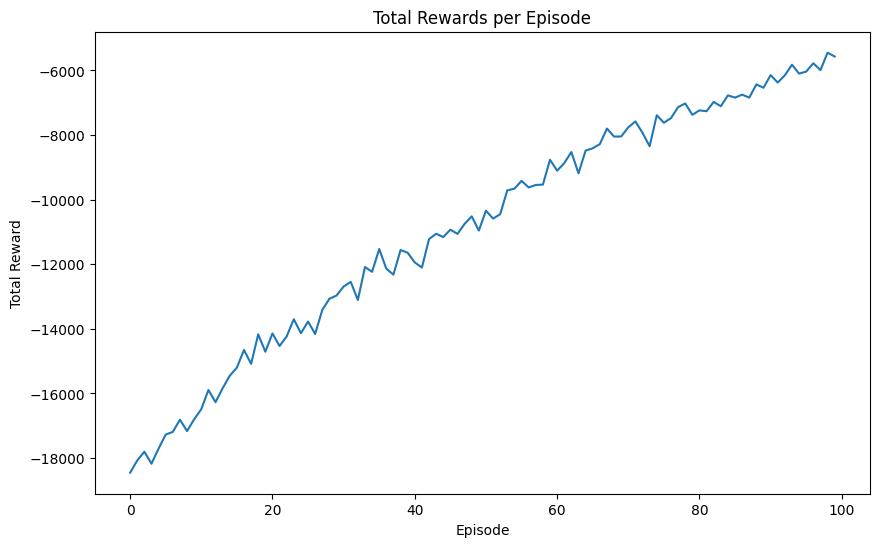

In [ ]:
# Initialize the environment
env = EnergyGridEnvironment(synthetic_data)

# Train the agent
q_table, total_rewards = train_agent(env)

# Plot total rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

Streaming output truncated to the last 5000 lines.
State: (1, 'Cloudy', 145.07143064099162, 48.40613956250128, 79.97472577388419, 77.20720952613348), Action: 2, Reward: -0.3255237900912319
State: (2, 'Night', 123.1993941811405, 71.27284359213081, 70.5692347501716, 60.64001025906998), Action: 2, Reward: 0.5170372128589001
State: (3, 'Sunny', 109.86584841970367, 40.40026316359353, 96.43600020608928, 17.497232480061676), Action: 2, Reward: -0.036846795760324236
State: (4, 'Sunny', 65.60186404424365, 72.17898108873028, 88.59744963051773, 26.702221310519985), Action: 2, Reward: 1.884576928926561
State: (5, 'Windy', 65.59945203362027, 25.28806585860149, 111.94205953944022, 29.73953656278272), Action: 2, Reward: 1.0722228776911351
State: (6, 'Night', 55.80836121681995, 66.60790623251785, 61.92657482892349, 33.207782828036045), Action: 2, Reward: 1.773784634704942
State: (7, 'Windy', 136.6176145774935, 70.85285798328418, 98.63207565330758, 60.88630527554538), Action: 2, Reward: 0.5414745097475

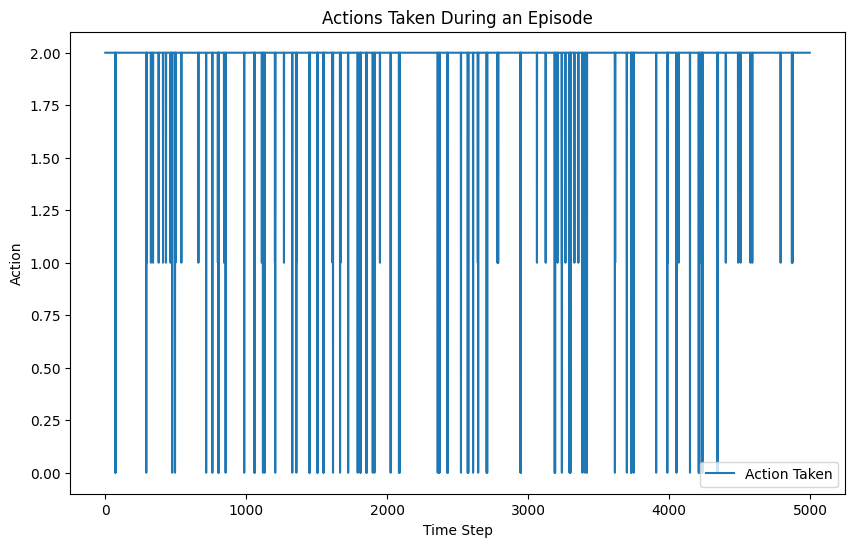

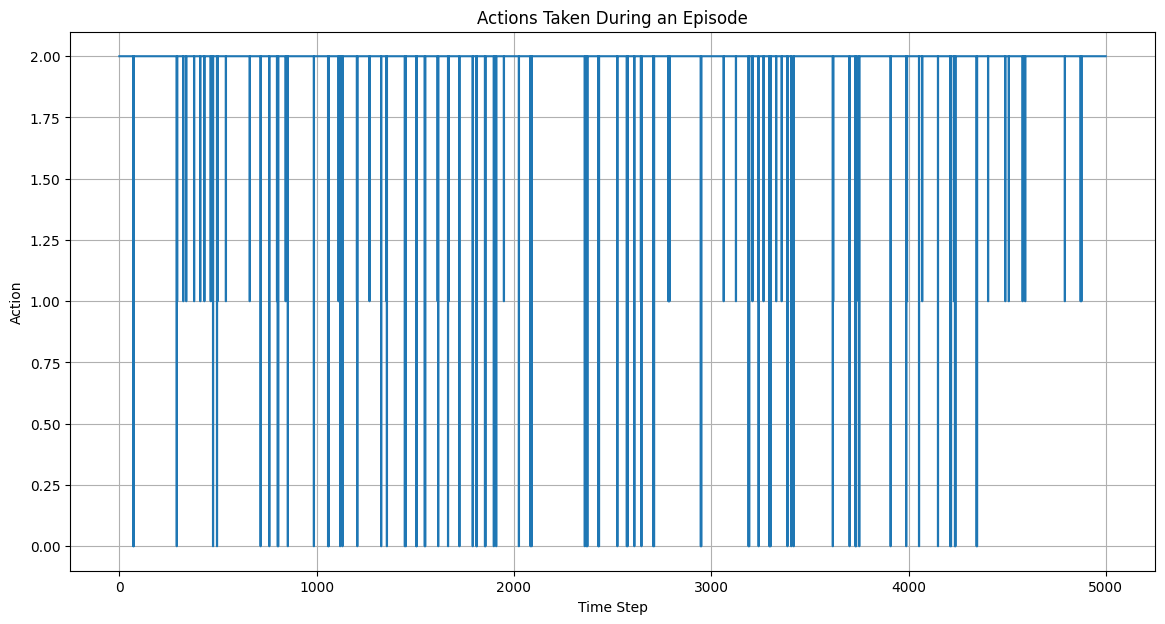

In [ ]:
# Demonstrate the learned policy
demonstrate_policy(env, q_table)